## Helper Function for a Radar (Spider) Plot

In [28]:
import numpy as np
import matplotlib.pyplot as plt
def_tick_size = 30
#import seaborn as sns # improves plot aesthetics


def _invert(x, limits):
    """inverts a value x on a scale from
    limits[0] to limits[1]"""
    return limits[1] - (x - limits[0])

def _scale_data(data, ranges):
    """scales data[1:] to ranges[0],
    inverts if the scale is reversed"""
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        assert (y1 <= d <= y2) or (y2 <= d <= y1)
    x1, x2 = ranges[0]
    d = data[0]
    if x1 > x2:
        d = _invert(d, (x1, x2))
        x1, x2 = x2, x1
    sdata = [d]
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        if y1 > y2:
            d = _invert(d, (y1, y2))
            y1, y2 = y2, y1
        sdata.append((d-y1) / (y2-y1) 
                     * (x2 - x1) + x1)
    return sdata

class ComplexRadar():
    def __init__(self, fig, variables, ranges,
                 n_ordinate_levels=6):
        angles = np.arange(0, 360, 360./len(variables))

        axes = [fig.add_axes([0.1,0.1,0.9,0.9],polar=True,
                label = "axes{}".format(i)) 
                for i in range(len(variables))]
        l, text = axes[0].set_thetagrids(angles, 
                                         labels=variables)
        [txt.set_rotation(angle-90) for txt, angle 
             in zip(text, angles)]
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.grid("off")
            ax.xaxis.set_visible(False)
            ax.tick_params(axis='both', labelsize=def_tick_size) ####################################
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i], 
                               num=n_ordinate_levels)
            gridlabel = ["{}".format(round(x,2)) 
                         for x in grid]
            if ranges[i][0] > ranges[i][1]:
                grid = grid[::-1] # hack to invert grid
                          # gridlabels aren't reversed
            gridlabel[0] = "" # clean up origin
            ax.set_rgrids(grid, labels=gridlabel,
                         angle=angles[i])
            #ax.spines["polar"].set_visible(False)
            ax.set_ylim(*ranges[i])
            ax.tick_params(axis='both', labelsize=def_tick_size) ######################################
        # variables for plotting
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)
        
    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

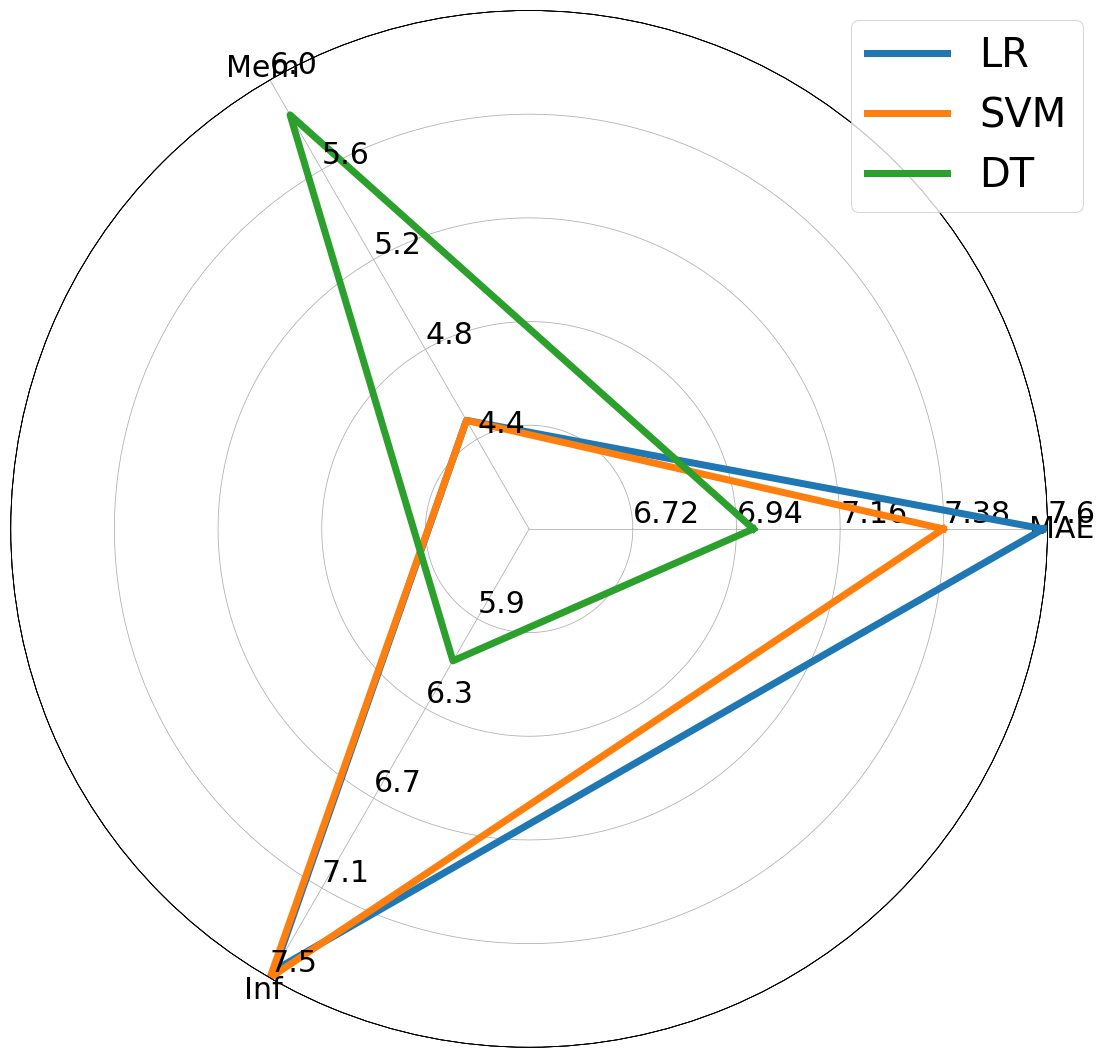

In [32]:
# example data
variables = ("MAE", "Mem", "Inf")

LR = (7.591222735251901 , 22772.0/507904*100 , 7.467039742008916)

SVM = (7.3789247987087805 , 22772.0/507904*100 , 7.499288627525372)

DT = (6.975881669420069 , 29684.0/507904*100, 6.0878307882007014)

RF = (6.848753677425909 , 393212.0/507904*100, 343.62088589585505)


ranges = [(0,0)]*len(LR)
for i in range(len(LR)):
    ranges[i] = (min(LR[i], SVM[i], DT[i]), max(LR[i], SVM[i], DT[i]))         
"""
for i in range(len(LR)):
    ranges[i] = (min(LR[i], SVM[i], DT[i], RF[i]), max(LR[i], SVM[i], DT[i], RF[i]))    
"""
ranges = [(6.5, 7.6), (4,6), (5.5,7.5)]

# plotting
fig1 = plt.figure(figsize=(16, 16))
radar = ComplexRadar(fig1, variables, ranges)

linewidth = 7
radar.plot(LR, label='LR', linewidth=linewidth)
radar.plot(SVM, label='SVM', linewidth=linewidth)
radar.plot(DT, label='DT', linewidth=linewidth)
#radar.plot(RF, label='RF')

#radar.fill(data, alpha=0.2)
fig1.legend(fontsize=40)
plt.show()


In [33]:
fig1.savefig('Radar_DBP_PyBadge.svg', format='svg', dpi=1200)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

take_log_PTT = 0 # if not log, then all values are positive & the outliers are as defined
Remove_HR_Outliers = 1 # =1 if required more constraints on HR ( 54.4 < HR < 155.8) 
Remove_PTT_Outliers = 1
Remove_BP_Outliers = 1

Remove_PTTm_Outliers = 0 #(PATf)
Remove_PTTh_Outliers = 0 #(PPG Max-to-Min)


All_Instants_Data2 = pd.read_csv('Extracted_Instants_Parameters_8secWindow_PTTm_PTTh_MAP_210621.csv')
All_Instants_Data2.dropna(inplace=True)
All_Instants_Data = All_Instants_Data2

if take_log_PTT != 1:
    All_Instants_Data['PTT'] = np.exp(All_Instants_Data['PTT']) ################ NOT LOG ANYMORE # By commenting this, it is log
    All_Instants_Data['PTTm'] = np.exp(All_Instants_Data['PTTm'])

# Removing BP Outliers
if Remove_BP_Outliers == 1:
    cond_BP = ((All_Instants_Data['SBP']<180) & (All_Instants_Data['SBP']>80)) & ((All_Instants_Data['DBP']<130) & (All_Instants_Data['DBP']>60))
    All_Instants_Data= All_Instants_Data.loc[cond_BP, ['PTTh','PTTm','PTT','HR','SBP', 'DBP','MAP']]

# Removing HR Outliers
if Remove_HR_Outliers == 1: 
    cond_HR = ((All_Instants_Data['HR']>54.4) & (All_Instants_Data['HR']<155.8))
    All_Instants_Data= All_Instants_Data.loc[cond_HR, ['PTTh','PTTm','PTT','HR','SBP', 'DBP','MAP']]
    
# Removing PTT Ouliers (outlier if PTT>1.5) # So far, considering PTT<0.5 range gave the best result
if Remove_PTT_Outliers == 1: 
    cond_PTT = (All_Instants_Data['PTT']<0.4) #& (All_Instants_Data['PTT']>0.2)#& (All_Instants_Data['PTT']>.015) #### KEEP <0.4 only ##################
    All_Instants_Data= All_Instants_Data.loc[cond_PTT, ['PTTh','PTTm','PTT','HR','SBP', 'DBP','MAP']]
    
# Removing PTTm (PATf) Outliers
if Remove_PTTm_Outliers == 1: 
    cond_PTTm = ((All_Instants_Data['PTTm']>0.7) & (All_Instants_Data['PTTm']<1.5))
    All_Instants_Data= All_Instants_Data.loc[cond_PTTm, ['PTTh','PTTm','PTT','HR','SBP', 'DBP','MAP']]
    
# Removing PTTh (PPG Max-to-Min) Outliers
if Remove_PTTh_Outliers == 1: 
    cond_PTTh = ((All_Instants_Data['PTTh']>1) & (All_Instants_Data['PTTh']<2))
    All_Instants_Data= All_Instants_Data.loc[cond_PTTh, ['PTTh','PTTm','PTT','HR','SBP', 'DBP','MAP']]

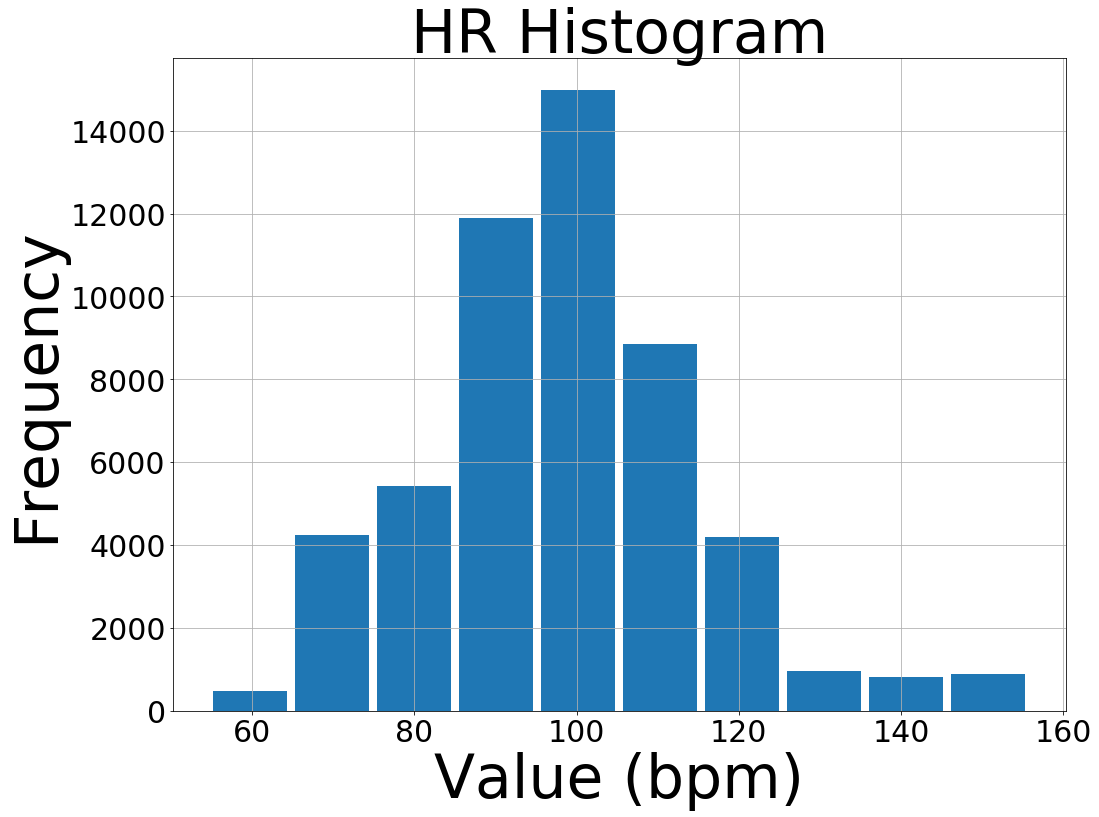

In [6]:
data_to_plot = 'HR'
title_dist = data_to_plot + " Histogram"
plt.rcParams["figure.figsize"]=16,12
#plt.legend(fontsize=40)
Data_intervals_minutes = All_Instants_Data[data_to_plot]
Data_intervals_minutes.hist(rwidth=0.9)
plt.title(title_dist,fontsize=60)
plt.xlabel("Value (bpm)",fontsize=60);
plt.ylabel("Frequency",fontsize=60);
plt.tick_params(axis='both', labelsize=30)
plt.savefig(title_dist+'_20210726'+'.svg', format='svg', dpi=1200)

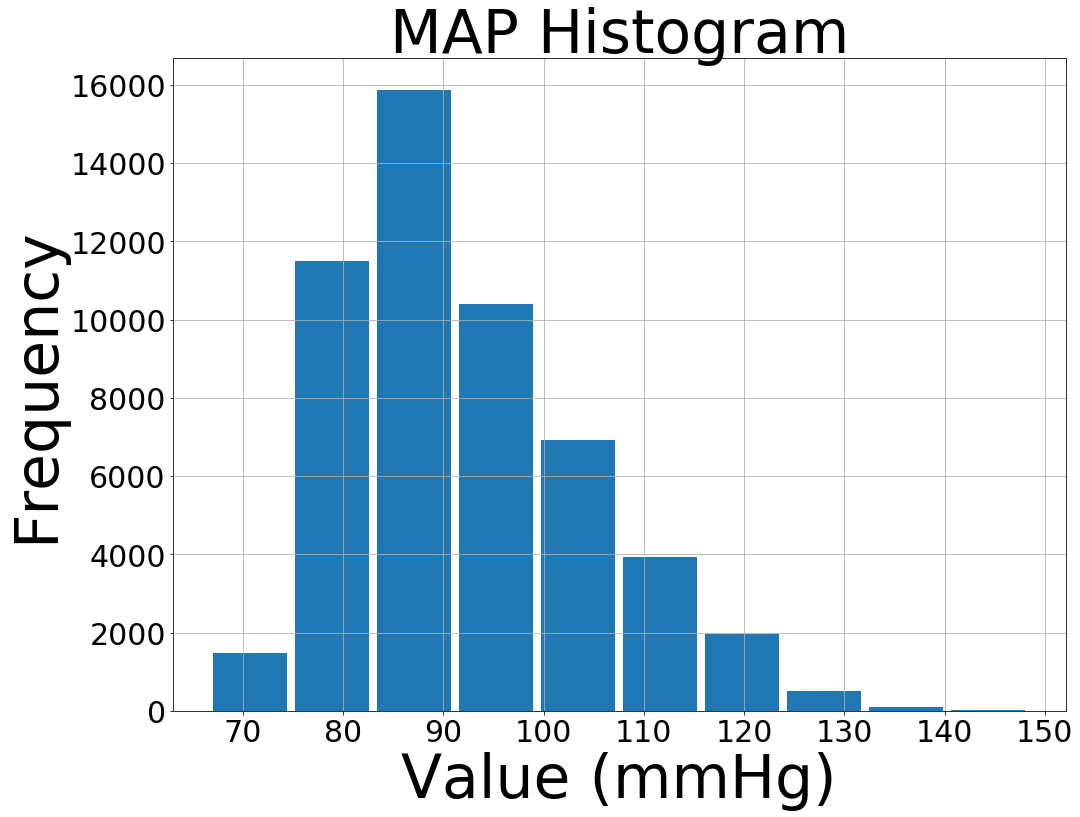

In [10]:
data_to_plot = 'MAP'
title_dist = data_to_plot + " Histogram"
plt.rcParams["figure.figsize"]=16,12
#plt.legend(fontsize=40)
Data_intervals_minutes = All_Instants_Data[data_to_plot]
Data_intervals_minutes.hist(rwidth=0.9)
plt.title(title_dist,fontsize=60)
plt.xlabel("Value (mmHg)",fontsize=60);
plt.ylabel("Frequency",fontsize=60);
plt.tick_params(axis='both', labelsize=30)
plt.savefig(title_dist+'_20210726'+'.svg', format='svg', dpi=1200)

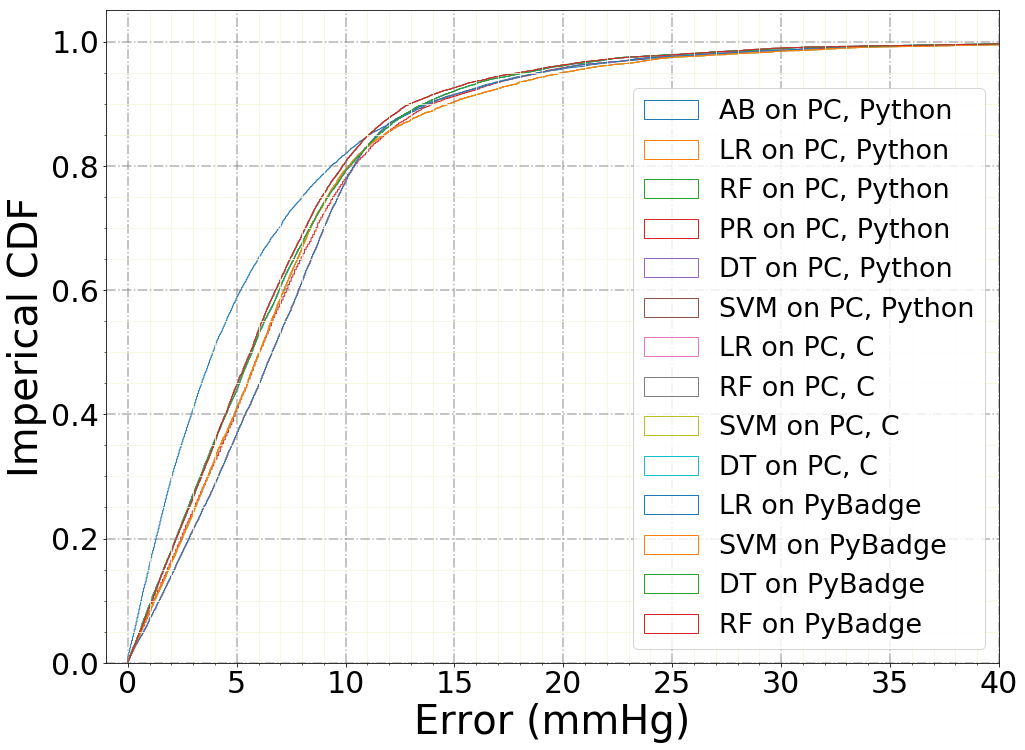

In [7]:
import joblib # to save: joblib.dump(model, model_file) .. to load: xyz = joblib.load("model_name_as_saved.pkl")
graph_list = ['DBP_Test_Error_AB.pkl', 'DBP_Test_Error_LR.pkl', 'DBP_Test_Error_RF.pkl', 'DBP_Test_Error_PR.pkl', 'DBP_Test_Error_DT.pkl', 'DBP_Test_Error_SVM.pkl', 'DBP_Test_Error_LR_C.pkl', 'DBP_Test_Error_RF_C.pkl', 'DBP_Test_Error_SVM_C.pkl', 'DBP_Test_Error_DT_C.pkl', 'DBP_Test_Error_LR_M.pkl', 'DBP_Test_Error_SVM_M.pkl', 'DBP_Test_Error_DT_M.pkl', 'DBP_Test_Error_RF_M.pkl']
legend_list = ['AB on PC, Python', 'LR on PC, Python', 'RF on PC, Python', 'PR on PC, Python', 'DT on PC, Python', 'SVM on PC, Python', 'LR on PC, C', 'RF on PC, C', 'SVM on PC, C', 'DT on PC, C', 'LR on PyBadge', 'SVM on PyBadge', 'DT on PyBadge', 'RF on PyBadge']

fig, ax = plt.subplots(figsize=(16, 12)); 
plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dashdot', lw=1.5)
#minor grid lines
plt.minorticks_on()
plt.xlim([-1,40]) ################################## was 55 
plt.xlabel('Error (mmHg)',fontsize=40)
plt.ylabel('Imperical CDF',fontsize=40)
#plt.title('CDF of DBP Estimation Error', fontsize=40)
plt.grid(b=True, which='minor', color='beige', alpha=0.8, ls='-', lw=1)
plt.tick_params(axis='both', labelsize=30)

for i in range(len(graph_list)):
    Test_Error = joblib.load('C:/Users/ahmedk1/Errors_for_CDFs/'+graph_list[i])
    ax.hist(abs(Test_Error), 1500, density=1, histtype='step', cumulative=True, label=legend_list[i], linewidth=1);
    plt.legend(fontsize=27, loc='lower right')
plt.savefig('CDFs2.svg', format='svg', dpi=1200)

## Graphs for DT & RF vs Nodes & Estimators

In [8]:
import pandas as pd
import numpy as np

take_log_PTT = 0 # if not log, then all values are positive & the outliers are as defined
Remove_HR_Outliers = 1 # =1 if required more constraints on HR ( 54.4 < HR < 155.8) 
Remove_PTT_Outliers = 1
Remove_BP_Outliers = 1

Remove_PTTm_Outliers = 0 #(PATf)
Remove_PTTh_Outliers = 0 #(PPG Max-to-Min)


All_Instants_Data2 = pd.read_csv('Extracted_Instants_Parameters_8secWindow_PTTm_PTTh_MAP_210621.csv')
All_Instants_Data2.dropna(inplace=True)
All_Instants_Data = All_Instants_Data2

if take_log_PTT != 1:
    All_Instants_Data['PTT'] = np.exp(All_Instants_Data['PTT']) ################ NOT LOG ANYMORE # By commenting this, it is log
    All_Instants_Data['PTTm'] = np.exp(All_Instants_Data['PTTm'])

# Removing BP Outliers
if Remove_BP_Outliers == 1:
    cond_BP = ((All_Instants_Data['SBP']<180) & (All_Instants_Data['SBP']>80)) & ((All_Instants_Data['DBP']<130) & (All_Instants_Data['DBP']>60))
    All_Instants_Data= All_Instants_Data.loc[cond_BP, ['PTTh','PTTm','PTT','HR','SBP', 'DBP','MAP']]

# Removing HR Outliers
if Remove_HR_Outliers == 1: 
    cond_HR = ((All_Instants_Data['HR']>54.4) & (All_Instants_Data['HR']<155.8))
    All_Instants_Data= All_Instants_Data.loc[cond_HR, ['PTTh','PTTm','PTT','HR','SBP', 'DBP','MAP']]
    
# Removing PTT Ouliers (outlier if PTT>1.5) # So far, considering PTT<0.5 range gave the best result
if Remove_PTT_Outliers == 1: 
    cond_PTT = (All_Instants_Data['PTT']<0.4) #& (All_Instants_Data['PTT']>0.2)#& (All_Instants_Data['PTT']>.015) #### KEEP <0.4 only ##################
    All_Instants_Data= All_Instants_Data.loc[cond_PTT, ['PTTh','PTTm','PTT','HR','SBP', 'DBP','MAP']]
    
# Removing PTTm (PATf) Outliers
if Remove_PTTm_Outliers == 1: 
    cond_PTTm = ((All_Instants_Data['PTTm']>0.7) & (All_Instants_Data['PTTm']<1.5))
    All_Instants_Data= All_Instants_Data.loc[cond_PTTm, ['PTTh','PTTm','PTT','HR','SBP', 'DBP','MAP']]
    
# Removing PTTh (PPG Max-to-Min) Outliers
if Remove_PTTh_Outliers == 1: 
    cond_PTTh = ((All_Instants_Data['PTTh']>1) & (All_Instants_Data['PTTh']<2))
    All_Instants_Data= All_Instants_Data.loc[cond_PTTh, ['PTTh','PTTm','PTT','HR','SBP', 'DBP','MAP']]

In [15]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from FilesfnCopy import RemoveGarbageEncodeObjects, display_scores
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from datetime import datetime
import m2cgen as m2c
import pickle
import joblib # to save: joblib.dump(model, model_file) .. to load: xyz = joblib.load("model_name_as_saved.pkl")


TARGET = 'DBP' # SBP or DBP or MAP
Reg_Model_vec = ['RF']


######################################################################
# Data Shuffling and Scaling
do_scaling = 0
temp_data = All_Instants_Data.loc[:, ['PTTh','PTTm','PTT','HR']]
train_copy2_tr, test_copy_tr, train_labels, test_labels = train_test_split(temp_data, All_Instants_Data[TARGET], test_size=0.2, random_state=42,shuffle=True)

# Data Scaling
if do_scaling == 1:
    train_pipeline = Pipeline([
            ('GarbageReomve_ObjectDataEncoding', RemoveGarbageEncodeObjects('train',train_copy2_tr)),
            ('std_scaler', StandardScaler()),
    ])
    train_copy2_tr = train_pipeline.fit_transform(train_copy2_tr) # now it is a complete matrix, mean=0, var=1
    # Preparing Test Data:
    test_pipeline = Pipeline([
            ('GarbageReomve_ObjectDataEncoding', RemoveGarbageEncodeObjects('test',test_copy_tr)),
            ('std_scaler', StandardScaler()),
    ])
    test_copy_tr = test_pipeline.fit_transform(test_copy_tr)
######################################################################


#DaTime = str(datetime.today().strftime('%Y%m%d-%H:%M'))
DaTime = ""
Results_file = TARGET+'_Results_'+ DaTime +'.txt'


for Reg_Model in Reg_Model_vec:
    Save_Code = 0 # default, unless enabled within alg
    
    # Setting Models', Var's, Files', and Graphs' names to be saved
    Code_file = TARGET + '_Code_' + Reg_Model + DaTime +'.txt'
    CDF_file = TARGET + '_Error_CDF_' + Reg_Model + DaTime +'.svg'
    Model_file = TARGET + '_Model_' + Reg_Model + DaTime +'.pkl'
    Train_Error_file = TARGET + '_Train_Error_' + Reg_Model + DaTime +'.pkl'
    Test_Error_file = TARGET + '_Test_Error_' + Reg_Model + DaTime +'.pkl'
    ######################################
    
    # Regression Models
        
    #      Random Forest
    if Reg_Model == "RF":
        Est = [2,4,8,16,32,64,128,256]
        MAE_RF = [0]*len(Est)
        Model_Size = [0]*len(Est)
        RF_data = pd.DataFrame()
        RF_data['log2(Est)'] = np.log2(Est)
        
        for i in range(len(Est)):
            forest_reg = RandomForestRegressor(n_estimators=Est[i], max_leaf_nodes=128, min_samples_leaf=100)
            forest_reg.fit(train_copy2_tr, train_labels)
            Test_Predictions = forest_reg.predict(test_copy_tr)
            Test_Error = test_labels - Test_Predictions
            MAE_RF[i] = np.mean(abs(Test_Error))
            Model_Size[i] = len(pickle.dumps(forest_reg, -1))/1000.0 # model size in KB
        RF_data['MAE'] = MAE_RF
        RF_data['Memory'] = Model_Size
        #Save_Code = 1
        #code = m2c.export_to_c(DT_reg)
        #joblib.dump(DT_reg, Model_file)
        RF_data.to_csv('RF_data.csv')
        
    
    if Reg_Model == "DT":
        Nodes = [2,4,8,16,32,64,128,256,512,1024,2048,4096]
        MAE_TR = [0]*len(Nodes)
        Model_Size = [0]*len(Nodes)
        DT_data = pd.DataFrame()
        DT_data['log2(Nodes)'] = np.log2(Nodes)
        for i in range(len(Nodes)):
            DT_reg = DecisionTreeRegressor(max_leaf_nodes=Nodes[i], min_samples_leaf=100)
            DT_reg.fit(train_copy2_tr, train_labels)    
            Test_Predictions = DT_reg.predict(test_copy_tr)
            # Calculate Prediction Errors & MAE
            Test_Error = test_labels - Test_Predictions
            MAE_TR[i] = np.mean(abs(Test_Error))
            Model_Size[i] = len(pickle.dumps(DT_reg, -1))/1000.0 # model size in KB
        DT_data['MAE'] = MAE_TR
        DT_data['Memory'] = Model_Size
        #DT_data.to_csv('DT_data.csv')
        

C:\Users\ahmedk1\.conda\envs\py371_sklearn0201\lib\site-packages\sklearn\ensemble\base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
C:\Users\ahmedk1\.conda\envs\py371_sklearn0201\lib\site-packages\sklearn\ensemble\base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your c

In [16]:
print(RF_data['MAE'])

0    6.952336
1    6.907473
2    6.866771
3    6.860826
4    6.857061
5    6.854694
6    6.853848
7    6.849704
Name: MAE, dtype: float64


In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

# for single csv file of 1,000 instants, use this directory & change file name as needed
#Data_Dir = "C:/1_Work/FANOS_lab/Reduced_Processed_Dataset_UCI_Kauchee/Generated_CSVs_from_Reduced_Dataset/12_Files_1000_instant_each/"
#File_name = "1.csv" # files 1 - 12, each with 1,000 instants

# To load all data from a single file: 
Data_Dir = "C:/1_Work/FANOS_lab/Reduced_Processed_Dataset_UCI_Kauchee/Generated_CSVs_from_Reduced_Dataset/Single_File/"
File_name = "All_Signals.csv" # All instants, 12,000, in a single csv file

# Now read data header-less then give the col names
Signals = pd.read_csv(Data_Dir + File_name, header=None) #.reset_index()
Signals.columns = ['PPG','ABP','ECG'] # adding columns' names

# Reading the instants' lengthes to be used for calculating indices
Data_Indices = pd.read_csv(Data_Dir+"Instants_Length.csv", header=None)
Data_Indices.columns = ['Num_Samples']

# Calculating Instant Indices, Start & End
End_indices = np.cumsum(Data_Indices["Num_Samples"])
Start_indices = np.append(0, End_indices) 

# Sampling frequency
Fs=125

In [ ]:
sig_num = 450
N_samp = round(1.5*125)
y1 = Signals['ECG'].iloc[Start_indices[sig_num]:End_indices[sig_num]+1]
y2 = Signals['PPG'].iloc[Start_indices[sig_num]:End_indices[sig_num]+1]
y3 = Signals['ABP'].iloc[Start_indices[sig_num]:End_indices[sig_num]+1]
from scipy.signal import find_peaks
t = 1000.0*np.arange(0,N_samp)/125.0 # time in msec
import matplotlib
matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30) 

plt.rcParams["figure.figsize"]=16,12
fig, axs = plt.subplots(3,sharex=True)
lw = 3
axs[0].plot(t, y1[0:N_samp], linewidth=lw)
axs[0].set_ylabel('ECG', fontsize=40)

axs[1].plot(t, y2[0:N_samp], linewidth=lw)
axs[1].set_ylabel('PPG', fontsize=40)

axs[2].plot(t, y3[0:N_samp], linewidth=lw)
axs[2].set_ylabel('ABP', fontsize=40)
axs[2].set_xlabel('time [msec]', fontsize=40)
fig.savefig('Signals.svg', format='svg', dpi=1200)